# Remembering handwritten digits with a Hopfield Network
**Filipe Chagas Ferraz**

## Introduction

**Hopfield Networks** are a type of recurrent neural network that function as associative memory systems, with the key ability to store stable patterns that can be retrieved from partial or noisy inputs. Invented by John Hopfield in 1982, these networks consist of binary nodes (neurons) that are symmetrically connected, meaning the weight between two neurons is the same in both directions.

The dynamics of a Hopfield Network are based on minimizing an energy function, which drives the system to a stable state (a local minimum in energy), corresponding to one of the stored patterns. They are useful for tasks like pattern recognition and solving combinatorial optimization problems. However, they have limitations in terms of storage capacity and can fall into spurious states (unrelated to stored patterns), especially when overloaded with too many patterns.

## Structure

| ![](https://media.geeksforgeeks.org/wp-content/uploads/20240313133541/Discrete-Hopfield-Network.webp) |
|---|
| Fig. 1 - structure of the Hopfield Network.|

In the fig 1, each $x_i$ represents a neuron with a binary state (1 or -1), and each $y_i \in \{-1,1\}$ is the corresponding output that indicates the state of $x_i$. For each pair of different neurons $(x_i, x_j)$, there is a connection weight $w_{i,j}$. These weights are calculated using the Hebbian Learning Rule.

## Experiment

In this experiment, a Hopfield Network will be trained to remember handwritten digits (MNIST dataset).

--- 

## Code

Importing libs...

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Loading data...

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
x = mnist['data'].reshape(-1, 28, 28)
y = mnist['target'].astype(int)

Preprocessing and previewing the data...

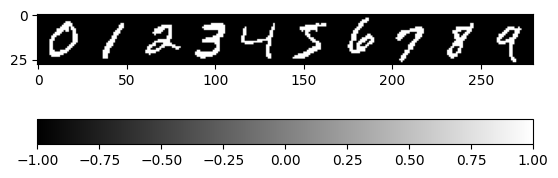

In [3]:
# --- Data pre-processing ---
patterns = [] # List of patterns to learn
for number in range(10):
    # Select a single image for each number in {0,1,...,9}
    for i in range(y.shape[0]):
        if number == y[i]:
            img = x[i]
            img = img.astype(float)
            img /= np.max(img)
            img -= 0.5
            img = np.sign(img) #binarize pixels (-1 or 1)
            patterns.append(img)
            break

# Preview
plt.imshow(np.hstack(patterns), cmap='gray')
plt.colorbar(location='bottom')
plt.show()

In the next cell, a function ``get_hopfield_matrix`` is defined to return a matrix $W$ with all the network weights calculated using the Hebbian rule for a single pattern (handwritten digit image). This matrix is computed as:

$$W = (O-I) \odot p \times p^T$$

where $p$ is a column vector with all the binary pixels of the image, $O$ is a square matrix filled with ones, $I$ is an indentity matrix, and $\odot$ is an element-wise product operator. Each entry of $W$ is defined as:

$$W_{i,j} = \begin{cases}p_i p_j, \quad i\neq j\\ 0, \quad i=j\end{cases}$$

In [4]:
def get_hopfield_matrix(pattern):
    # Returns a matrix with the weights of the Hopfield Net
    pvec = np.expand_dims(pattern.flatten(), axis=1) # Convert image to column vector
    mat = np.matmul(pvec, pvec.T) # External product
    np.fill_diagonal(mat, 0) # Set all diag entries to 0
    return mat

# Test
hm = get_hopfield_matrix(patterns[0])
hm

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]], shape=(784, 784))

In the next cell, a function ``update_hopfield_state`` is defined. This function simulate a discrete step in the temporal evolution of neuron states during the process of recalling a learned pattern. This state change is defined as:

$$x_i' = \text{sign}\left(\sum_{j} W_{i,j} x_j\right)$$

where $i$ is a random neuron index and $x_i'$ is the updated state of the i-th neuron.

In [5]:
def update_hopfield_state(curr_state, hopfield_matrix):
    # Update a random neurom and return the updated network stated
    new_state = curr_state.copy()
    i = np.random.randint(0, curr_state.shape[0])
    new_state[i] = np.sign(curr_state.dot(hopfield_matrix[i, :]))
    return new_state

In the next cell, a function to calculate the network energy is defined. This energy is defined as:

$$E = -\frac{1}{2}\sum_{i}\sum_{j} W_{i,j}x_i x_j$$

or, in matrix form (with $x$ as a column vector):

$$E = - \frac{1}{2} x^T W x$$

In [6]:
def hopfield_net_energy(curr_state, hopfield_matrix):
    # Returns the energy of a given network state
    pvec = np.expand_dims(curr_state, axis=1)
    return -(1/2)*np.matmul(pvec.T, np.matmul(hopfield_matrix, pvec))[0,0]

# Test
hopfield_net_energy(np.sign(np.random.random(28**2)-0.5), hm)

np.float64(264.0)

In the next cell, the HN recall process is simulated once for each digit from 0 to 9.

In [7]:
# --- Simulation ---

n_neurons = patterns[0].shape[0]*patterns[0].shape[1] # Number of neurons
im_shape = patterns[0].shape # Image shape
n_steps = 3000 # Number of update steps

lists = dict() # Dict of results

for number in range(10): # For each number to remember
    print(f'Processing number {number}...')
    im_list = [] # Temporal evolution of network states as images
    en_list = [] # Temporal evolution of network energy
    pattern = patterns[number] # Current learned pattern
    hm = get_hopfield_matrix(pattern) # Matrix with the weights of the network

    state = np.sign(np.random.random(n_neurons)-1/2) # Current network state (initially random)
    for step in range(n_steps):
        state = update_hopfield_state(state, hm)
        im_list.append(np.reshape(state, im_shape))
        en_list.append(hopfield_net_energy(state, hm))

    lists[number] = {
        'im_list': im_list,
        'en_list': en_list,
        'pattern': pattern,
        'hm': hm
    }

Processing number 0...
Processing number 1...
Processing number 2...
Processing number 3...
Processing number 4...
Processing number 5...
Processing number 6...
Processing number 7...
Processing number 8...
Processing number 9...


The following cell plot the results as an animation.

In [8]:
# --- Animated plot generation ---

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8), constrained_layout=True)
fig.suptitle('Remembering handwritten digits with Hopfield Networks (by Filipe Chagas)')

ax[0][0].set_title('Learned Pattern')
ax[0][0].set_xlabel('j')
ax[0][0].set_ylabel('i')
lp_ax = ax[0][0].imshow(lists[0]['pattern'], cmap='gray')

ax[0][1].set_title('Network Weights')
ax[0][1].set_xlabel('j')
ax[0][1].set_ylabel('i')
hm_ax = ax[0][1].imshow(lists[0]['hm'])

ax[1][0].set_title('Network State')
ax[1][0].set_xlabel('j')
ax[1][0].set_ylabel('i')
state_ax = ax[1][0].imshow(im_list[0], cmap='gray')

ax[1][1].set_title('Network Energy')
ax[1][1].set_xlabel('Step')
ax[1][1].set_ylabel('Value')
en_ax, = ax[1][1].plot([], [])
ax[1][1].grid()
ax[1][1].axis([
    0,
    len(en_list),
    np.min([lists[number]['en_list'][-1] for number in range(10)]),
    np.max([lists[number]['en_list'][0] for number in range(10)])*2
])

fig.colorbar(hm_ax, location='right')
fig.colorbar(state_ax, location='bottom')

steps_per_frame = 50

def animate(frame_i):
    k = (frame_i * steps_per_frame) % n_steps
    number = (frame_i * steps_per_frame) // n_steps

    lp_ax.set_data(lists[number]['pattern'])
    hm_ax.set_data(lists[number]['hm'])
    state_ax.set_data(lists[number]['im_list'][k])
    en_ax.set_data(np.arange(k), lists[number]['en_list'][:k])

ani = FuncAnimation(fig, animate, frames=10*n_steps//steps_per_frame, interval=50)
plt.close()

In [9]:
ani.save('hopfield_network_filipe.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


Result of **hopfield_network_filipe.gif**:

![](hopfield_network_filipe.gif)